# GAMA-09 master catalogue
## Preparation of Canada France Hawaii Telescope Lensing Survey (CFHTLenS) data

Isaac Newton Telescope / Wide Field Camera (INT/WFC) catalogue: the catalogue comes from `dmu0_CFHTLenS`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The kron magnitude, there doesn't appear to be aperture magnitudes. This may mean the survey is unusable.

We use the publication year 2012 for the epoch.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
44f1ae0 (Thu Nov 30 18:27:54 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "cfhtlens_ra"
DEC_COL = "cfhtlens_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'id': "cfhtlens_id",
        'ALPHA_J2000': "cfhtlens_ra",
        'DELTA_J2000': "cfhtlens_dec",
        'CLASS_STAR':  "cfhtlens_stellarity",
        'MAG_u': "m_cfhtlens_u",
        'MAGERR_u': "merr_cfhtlens_u",
        'MAG_g': "m_cfhtlens_g",
        'MAGERR_g': "merr_cfhtlens_g",
        'MAG_r': "m_cfhtlens_r",
        'MAGERR_r': "merr_cfhtlens_r",
        'MAG_i': "m_cfhtlens_i",
        'MAGERR_i': "merr_cfhtlens_i",
        'MAG_z': "m_cfhtlens_z",
        'MAGERR_z': "merr_cfhtlens_z",

    })


catalogue = Table.read("../../dmu0/dmu0_CFHTLenS/data/CFHTLenS_GAMA-09.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2012 #Year of publication

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        

        catalogue[col][catalogue[col] <= 0] = np.nan
        catalogue[errcol][catalogue[errcol] <= 0] = np.nan  
        catalogue[col][catalogue[col] > 90.] = np.nan
        catalogue[errcol][catalogue[errcol] > 90.] = np.nan         

        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in greater


In [6]:
catalogue[:10].show_in_notebook()

idx,cfhtlens_id,cfhtlens_ra,cfhtlens_dec,cfhtlens_stellarity,m_cfhtlens_u,merr_cfhtlens_u,m_cfhtlens_g,merr_cfhtlens_g,m_cfhtlens_r,merr_cfhtlens_r,m_cfhtlens_i,merr_cfhtlens_i,m_cfhtlens_z,merr_cfhtlens_z,f_cfhtlens_u,ferr_cfhtlens_u,flag_cfhtlens_u,f_cfhtlens_g,ferr_cfhtlens_g,flag_cfhtlens_g,f_cfhtlens_r,ferr_cfhtlens_r,flag_cfhtlens_r,f_cfhtlens_i,ferr_cfhtlens_i,flag_cfhtlens_i,f_cfhtlens_z,ferr_cfhtlens_z,flag_cfhtlens_z
0,W2m0p2_210647,133.0356386,-1.955668769,0.657913,26.0454,0.0804,25.0773,0.0214,25.0385,0.038,24.7963,0.0275,24.2867,0.0683,0.138624,0.0102653,False,0.338127,0.00666454,False,0.350429,0.0122648,False,0.438005,0.011094,False,0.700358,0.0440572,False
1,W2m0p2_210971,133.0336776,-1.955068969,0.0278947,23.3976,0.0107,22.9297,0.0043,22.6904,0.0062,21.9814,0.0032,21.8027,0.0091,1.5884,0.0156538,False,2.4441,0.00967974,False,3.04677,0.0173983,False,5.85383,0.017253,False,6.90112,0.0578411,False
2,W2m0p2_211087,133.0324869,-1.953935994,0.0976754,26.4152,0.1133,25.3959,0.0279,24.971,0.0364,24.027,0.0148,23.707,0.0422,0.0986099,0.0102903,False,0.252139,0.00647917,False,0.372906,0.0125019,False,0.88961,0.0121265,False,1.19454,0.0464288,False
3,W2m0p2_211139,133.036176,-1.953774254,0.0122349,25.1198,0.0337,24.7661,0.0149,24.5221,0.0224,24.0741,0.0136,23.6954,0.0372,0.325147,0.0100922,False,0.45036,0.00618047,False,0.563845,0.0116328,False,0.851844,0.0106702,False,1.20737,0.0413674,False
4,W2m0p2_211150,133.0332197,-1.95373055,0.665074,nan,nan,25.9988,0.0555,25.9858,0.0986,25.4231,0.054,nan,nan,nan,nan,False,0.144704,0.00739687,False,0.146447,0.0132994,False,0.245901,0.0122301,False,nan,nan,False
5,W2m0p2_211262,133.0320383,-1.953325712,0.525169,nan,nan,nan,nan,nan,nan,25.2748,0.0637,nan,nan,nan,nan,False,nan,nan,False,nan,nan,False,0.28189,0.0165385,False,nan,nan,False
6,W2m0p2_211277,133.0283815,-1.954071785,0.010205,24.3982,0.0246,23.923,0.0099,23.3503,0.0111,22.6908,0.0058,22.3468,0.0154,0.632005,0.0143196,False,0.979039,0.00892711,False,1.65913,0.0169621,False,3.04565,0.0162698,False,4.181,0.0593029,False
7,W2m0p2_211295,133.03748,-1.95318253,0.297635,26.9792,0.1685,nan,nan,25.459,0.0554,24.1354,0.0146,23.3713,0.0294,0.058657,0.00910322,False,nan,nan,False,0.237903,0.0121391,False,0.805081,0.010826,False,1.62735,0.044066,False
8,W2m0p2_211296,133.0363248,-1.953294325,0.97935,26.5947,0.1164,24.954,0.0166,23.8193,0.0122,22.5217,0.0043,21.8371,0.0074,0.0835834,0.00896084,False,0.378791,0.0057914,False,1.07716,0.0121036,False,3.55894,0.014095,False,6.6859,0.0455688,False
9,W2m0p2_211484,133.0398925,-1.95233707,0.432357,25.5706,0.0539,25.3112,0.0256,25.1691,0.042,24.8323,0.029,24.2942,0.0684,0.214664,0.0106567,False,0.272596,0.00642741,False,0.310713,0.0120195,False,0.423721,0.0113176,False,0.695536,0.0438179,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['merr_cfhtlens_u', 
             'merr_cfhtlens_g', 
             'merr_cfhtlens_r', 
             'merr_cfhtlens_i',
             'merr_cfhtlens_z']
FLAG_NAME = 'cfhtlens_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 569071 sources.
The cleaned catalogue has 569066 sources (5 removed).
The cleaned catalogue has 5 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_GAMA-09.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

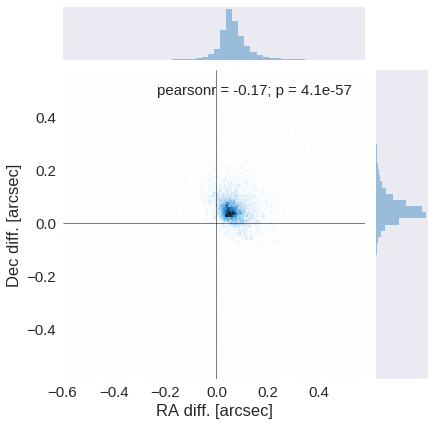

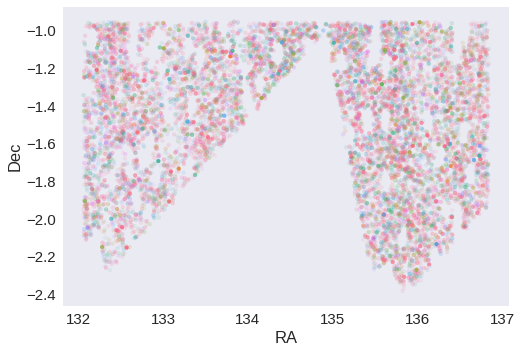

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.059877701926325244 arcsec
Dec correction: -0.04593033190820606 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

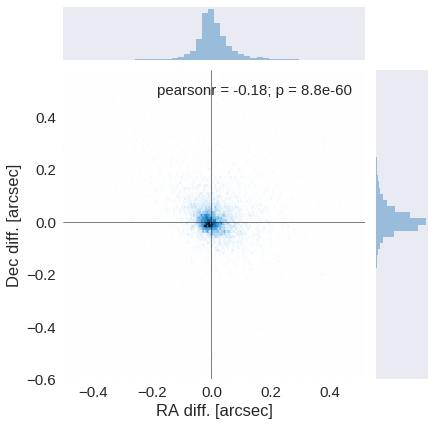

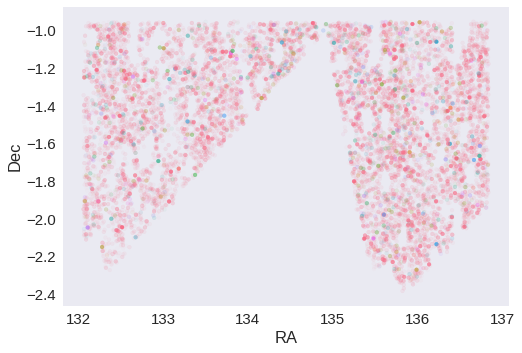

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "cfhtlens_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

8602 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/CFHTLENS.fits".format(OUT_DIR), overwrite=True)